In [1]:
# imports

import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter

In [2]:
# More imports for our traditional machine learning

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [3]:
# NLP related imports

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [4]:
# Finally, more imports for more advanced machine learning

from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [5]:
# Constants - used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [6]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [7]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [8]:
# One more import after logging in

from items import Item

In [9]:
%matplotlib inline

In [10]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

A rather pleasing Test Harness that will evaluate any model against 250 items from the Test set

And show us the results in a visually satisfying way.

You write a function of this form:

def my_prediction_function(item):
    # my code here
    return my_estimate
And then you call:

Tester.test(my_prediction_function)

To evaluate your model.

In [11]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()

In [12]:
def random_pricer(item):
    return random.randrange(1,1000)

1: Guess: $655.00 Truth: $319.97 Error: $335.03 SLE: 0.51 Item: Cetol SRD Natural - 5 Gallons
2: Guess: $115.00 Truth: $184.99 Error: $69.99 SLE: 0.22 Item: Rhino-Rack Aluminum Roof Rack Tracks 58....
3: Guess: $26.00 Truth: $193.39 Error: $167.39 SLE: 3.90 Item: Delta Faucet 51600-SSN/An/A Includes 60"...
4: Guess: $760.00 Truth: $153.99 Error: $606.01 SLE: 2.53 Item: Texan Auto Seat Cover - Driver Bottom Le...
5: Guess: $282.00 Truth: $156.83 Error: $125.17 SLE: 0.34 Item: Dawn Enterprises FE2-4RUN Finished End B...
6: Guess: $251.00 Truth: $339.00 Error: $88.00 SLE: 0.09 Item: DIDER 22'' Farmhouse Ceiling Fan with Li...
7: Guess: $229.00 Truth: $17.99 Error: $211.01 SLE: 6.22 Item: Floor Lamp Shade 2 Pack Torchiere Lamp S...
8: Guess: $143.00 Truth: $180.75 Error: $37.75 SLE: 0.05 Item: OE Wheels LLC TY09-17075-6550-30MS Silve...
9: Guess: $755.00 Truth: $248.35 Error: $506.65 SLE: 1.23 Item: Taco 0011-009RP Series Replacement Cartr...
10: Guess: $105.00 Truth: $98.95 Error: $6.05 S

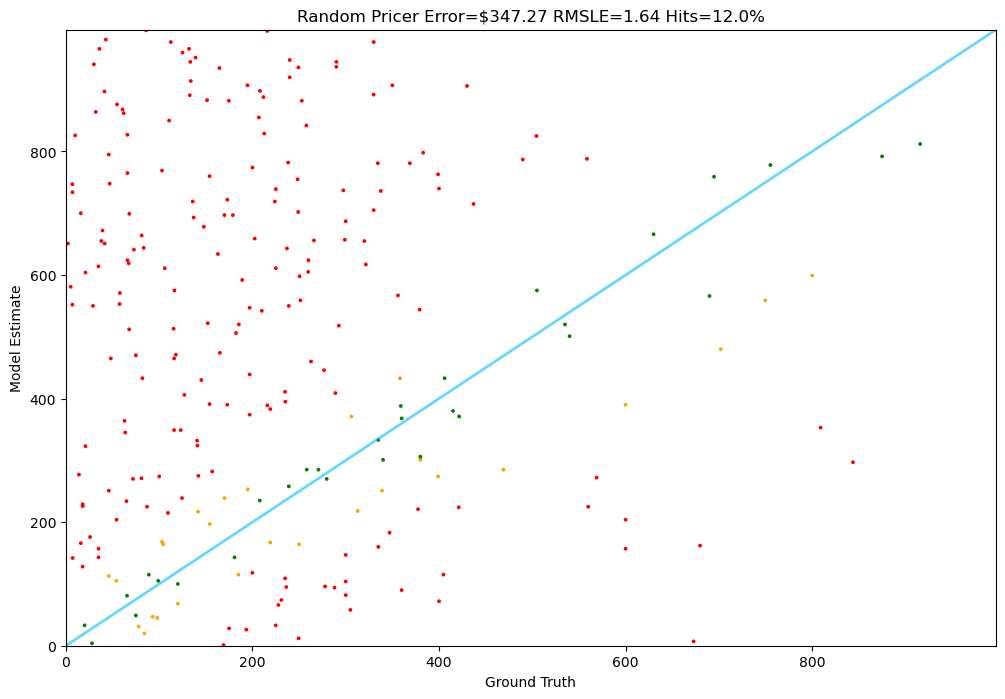

In [13]:
# Set the random seed

random.seed(42)

# Run our TestRunner
Tester.test(random_pricer)

In [14]:

training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)

def constant_pricer(item):
    return training_average

1: Guess: $220.52 Truth: $319.97 Error: $99.45 SLE: 0.14 Item: Cetol SRD Natural - 5 Gallons
2: Guess: $220.52 Truth: $184.99 Error: $35.53 SLE: 0.03 Item: Rhino-Rack Aluminum Roof Rack Tracks 58....
3: Guess: $220.52 Truth: $193.39 Error: $27.13 SLE: 0.02 Item: Delta Faucet 51600-SSN/An/A Includes 60"...
4: Guess: $220.52 Truth: $153.99 Error: $66.53 SLE: 0.13 Item: Texan Auto Seat Cover - Driver Bottom Le...
5: Guess: $220.52 Truth: $156.83 Error: $63.69 SLE: 0.11 Item: Dawn Enterprises FE2-4RUN Finished End B...
6: Guess: $220.52 Truth: $339.00 Error: $118.48 SLE: 0.18 Item: DIDER 22'' Farmhouse Ceiling Fan with Li...
7: Guess: $220.52 Truth: $17.99 Error: $202.53 SLE: 6.03 Item: Floor Lamp Shade 2 Pack Torchiere Lamp S...
8: Guess: $220.52 Truth: $180.75 Error: $39.77 SLE: 0.04 Item: OE Wheels LLC TY09-17075-6550-30MS Silve...
9: Guess: $220.52 Truth: $248.35 Error: $27.83 SLE: 0.01 Item: Taco 0011-009RP Series Replacement Cartr...
10: Guess: $220.52 Truth: $98.95 Error: $121.57 SL

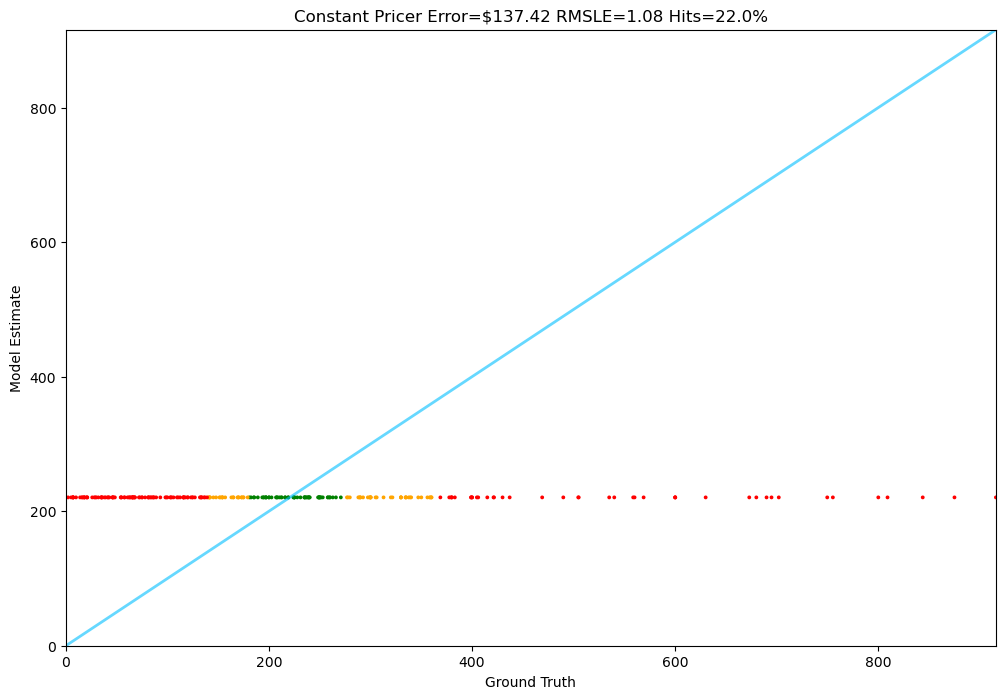

In [15]:
# Run our constant predictor
Tester.test(constant_pricer)

In [16]:
# feature engineering example

for item in train:
    item.features = json.loads(item.details) #using json to convert string into python dict
for item in test:
    item.features = json.loads(item.details)

In [17]:
# Look at 20 most common features in training set

feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(40)

[('Date First Available', 359981),
 ('Item Weight', 350469),
 ('Manufacturer', 349300),
 ('Brand', 340264),
 ('Best Sellers Rank', 330411),
 ('Item model number', 277537),
 ('Product Dimensions', 262522),
 ('Color', 183704),
 ('Is Discontinued By Manufacturer', 169808),
 ('Manufacturer Part Number', 145012),
 ('Material', 137406),
 ('Country of Origin', 121408),
 ('Style', 77583),
 ('Special Feature', 74679),
 ('Part Number', 74542),
 ('Batteries Required?', 73594),
 ('Package Dimensions', 72814),
 ('Item Dimensions LxWxH', 71341),
 ('Included Components', 67486),
 ('Model', 65072),
 ('Item Package Quantity', 58191),
 ('Size', 58164),
 ('Batteries Included?', 56769),
 ('OEM Part Number', 56067),
 ('Special Features', 53731),
 ('Exterior', 50593),
 ('Power Source', 50278),
 ('Vehicle Service Type', 49440),
 ('Finish Type', 46193),
 ('Voltage', 46062),
 ('Mounting Type', 37988),
 ('Model Name', 37572),
 ('Shape', 34818),
 ('Finish', 31939),
 ('Number of Items', 31896),
 ('Connectivity Te

In [35]:
# dropping items that are discontinued

def is_discontinued(item):
    return item.features.get('Is Discontinued By Manufacturer', False)

items = [item for item in train if not is_discontinued(item)]

In [36]:
# Now some janky code to pluck out the Item Weight
# Don't worry too much about this: spoiler alert, it's not going to be much use in training!

def get_weight(items):
    weight_str = items.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [37]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w] #filters out any nones

In [38]:
average_weight = sum(weights)/len(weights)
average_weight

13.576449677262719

In [39]:
def get_weight_with_default(items):
    weight = get_weight(items)
    return weight or average_weight #if weight is none it swaps it out with the average weight

In [40]:
def get_rank(items):
    rank_dict = items.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [41]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

380615.49969255767

In [42]:
def get_rank_with_default(items):
    rank = get_rank(items)
    return rank or average_rank #same, give average rank if there's no rank

In [43]:
def get_text_length(items):
    return len(items.test_prompt()) #how long is the text prompt

In [44]:
# investigate the brands

brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1

# Look at most common 40 brands

brands.most_common(40)

[('HP', 5527),
 ('Power Stop', 3592),
 ('Dell', 3266),
 ('Detroit Axle', 2721),
 ('Lenovo', 2445),
 ('Dorman', 2124),
 ('SAMSUNG', 1771),
 ('BUYAUTOPARTS!', 1726),
 ('ACDelco', 1596),
 ('Evan Fischer', 1419),
 ('ASUS', 1398),
 ('Sony', 1279),
 ('Canon', 1220),
 ('Kohler', 1150),
 ('Callahan BRAKE PARTS', 1141),
 ('CURT', 1125),
 ('R1 Concepts', 1062),
 ('Rareelectrical', 955),
 ('Coverking', 947),
 ('Garage-Pro', 880),
 ('Kingston Brass', 852),
 ('Spectra Premium', 835),
 ('Moen', 830),
 ('Auto Dynasty', 823),
 ('WeatherTech', 821),
 ('DELTA FAUCET', 804),
 ('Apple', 791),
 ('Generic', 784),
 ('Cardone', 772),
 ('APS', 768),
 ('K&N', 743),
 ('GM', 741),
 ('EBC Brakes', 728),
 ('Walker', 725),
 ('AKKON', 657),
 ('SPEC-D TUNING', 631),
 ('TYC', 630),
 ('Covercraft', 619),
 ('A-Premium', 615),
 ('Intel', 608)]

In [45]:
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(items):
    brand = items.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

In [46]:
def get_features(items):
    return {
        "weight": get_weight_with_default(items),
        "rank": get_rank_with_default(items),
        "text_length": get_text_length(items),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(items) else 0
    }

In [47]:
# Look at features in a training item
get_features(train[0])

{'weight': 13.576449677262719,
 'rank': 380615.49969255767,
 'text_length': 806,
 'is_top_electronics_brand': 0}

In [49]:
# A utility function to convert our features into a pandas dataframe

def list_to_dataframe(item):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

In [31]:
# Traditional Linear Regression!

np.random.seed(42)

# Separate features and target
feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# Predict the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

weight: 0.2641410844672656
rank: 5.1845367270841685e-05
text_length: 0.0066845757578094175
is_top_electronics_brand: 198.29126471786915
Intercept: 182.9614636778466
Mean Squared Error: 33245.56349413861
R-squared Score: 0.016681067761570634


In [50]:
# Function to predict price for a new item

def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: $217.36 Truth: $319.97 Error: $102.61 SLE: 0.15 Item: Cetol SRD Natural - 5 Gallons
2: Guess: $214.35 Truth: $184.99 Error: $29.36 SLE: 0.02 Item: Rhino-Rack Aluminum Roof Rack Tracks 58....
3: Guess: $190.35 Truth: $193.39 Error: $3.04 SLE: 0.00 Item: Delta Faucet 51600-SSN/An/A Includes 60"...
4: Guess: $293.79 Truth: $153.99 Error: $139.80 SLE: 0.41 Item: Texan Auto Seat Cover - Driver Bottom Le...
5: Guess: $218.88 Truth: $156.83 Error: $62.05 SLE: 0.11 Item: Dawn Enterprises FE2-4RUN Finished End B...
6: Guess: $196.16 Truth: $339.00 Error: $142.84 SLE: 0.30 Item: DIDER 22'' Farmhouse Ceiling Fan with Li...
7: Guess: $189.51 Truth: $17.99 Error: $171.52 SLE: 5.32 Item: Floor Lamp Shade 2 Pack Torchiere Lamp S...
8: Guess: $224.83 Truth: $180.75 Error: $44.08 SLE: 0.05 Item: OE Wheels LLC TY09-17075-6550-30MS Silve...
9: Guess: $207.60 Truth: $248.35 Error: $40.75 SLE: 0.03 Item: Taco 0011-009RP Series Replacement Cartr...
10: Guess: $208.22 Truth: $98.95 Error: $109.27 S

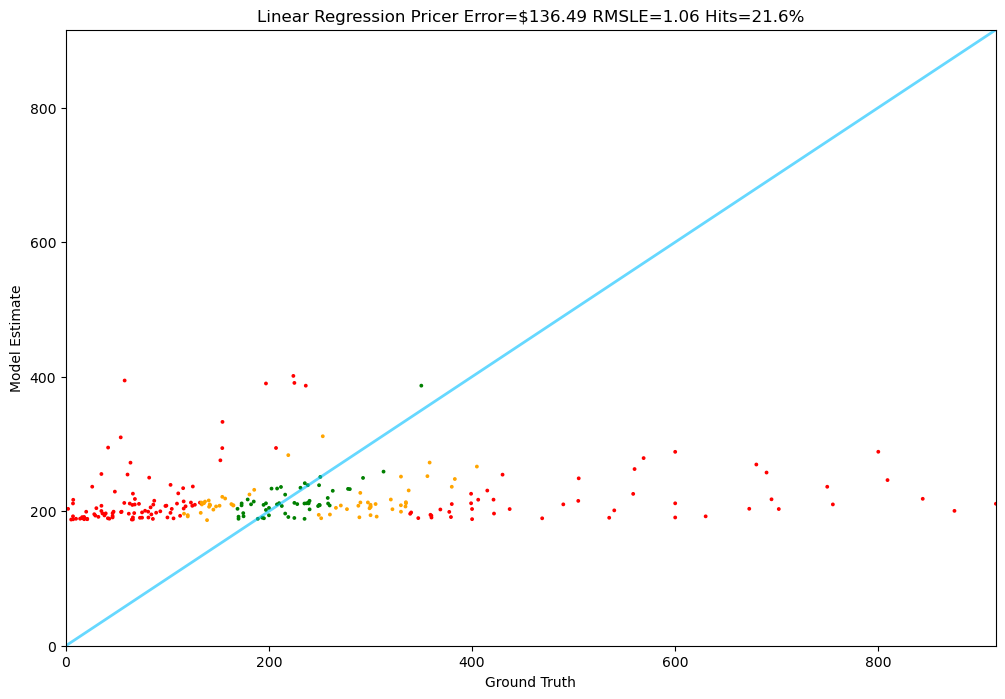

In [51]:
Tester.test(linear_regression_pricer)

In [53]:
# For the next few models, we prepare our documents and prices
# Note that we use the test prompt for the documents, otherwise we'll reveal the answer!!

prices = np.array([float(item.price) for item in train]) #list of all the training prices
documents = [item.test_prompt() for item in train] #test prompts from training, training prompt would include the price, so use test prompt

In [54]:
# Use the CountVectorizer for a Bag of Words model

np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

LinearRegression()

In [55]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $181.00 Truth: $319.97 Error: $138.97 SLE: 0.32 Item: Cetol SRD Natural - 5 Gallons
2: Guess: $391.09 Truth: $184.99 Error: $206.10 SLE: 0.56 Item: Rhino-Rack Aluminum Roof Rack Tracks 58....
3: Guess: $467.51 Truth: $193.39 Error: $274.12 SLE: 0.77 Item: Delta Faucet 51600-SSN/An/A Includes 60"...
4: Guess: $201.22 Truth: $153.99 Error: $47.23 SLE: 0.07 Item: Texan Auto Seat Cover - Driver Bottom Le...
5: Guess: $207.26 Truth: $156.83 Error: $50.43 SLE: 0.08 Item: Dawn Enterprises FE2-4RUN Finished End B...
6: Guess: $273.38 Truth: $339.00 Error: $65.62 SLE: 0.05 Item: DIDER 22'' Farmhouse Ceiling Fan with Li...
7: Guess: $45.95 Truth: $17.99 Error: $27.96 SLE: 0.82 Item: Floor Lamp Shade 2 Pack Torchiere Lamp S...
8: Guess: $300.13 Truth: $180.75 Error: $119.38 SLE: 0.25 Item: OE Wheels LLC TY09-17075-6550-30MS Silve...
9: Guess: $136.45 Truth: $248.35 Error: $111.90 SLE: 0.35 Item: Taco 0011-009RP Series Replacement Cartr...
10: Guess: $186.23 Truth: $98.95 Error: $87.28 S

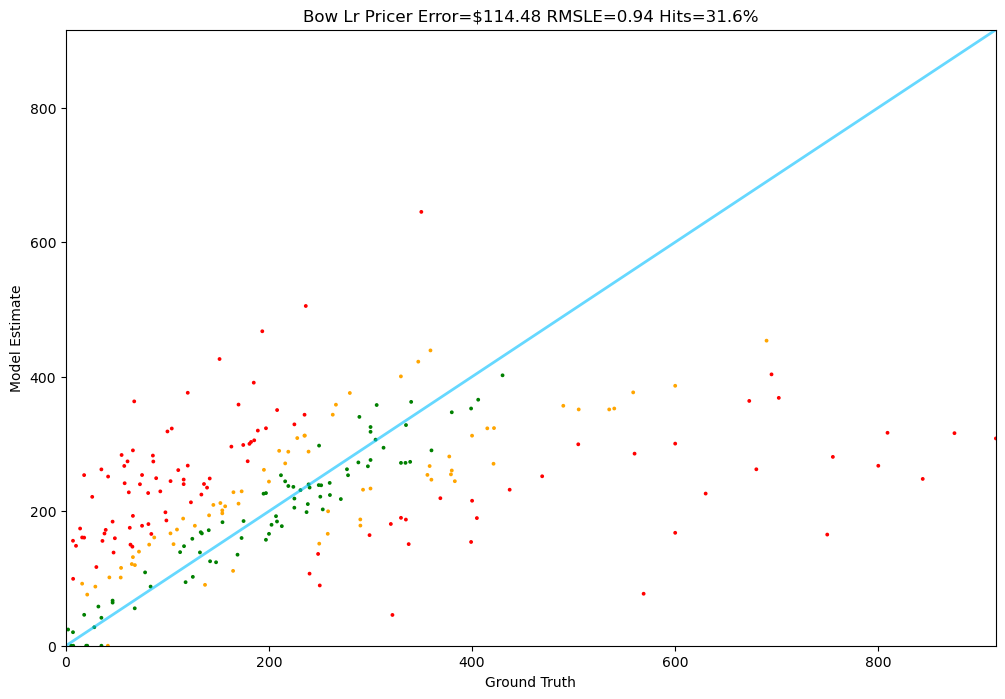

In [56]:
Tester.test(bow_lr_pricer)

In [57]:
# The amazing word2vec model, implemented in gensim NLP library

np.random.seed(42)

# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [58]:
# This step of averaging vectors across the document is a weakness in our approach

def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

In [59]:
# Run Linear Regression on word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

LinearRegression()

In [60]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Guess: $196.46 Truth: $319.97 Error: $123.51 SLE: 0.24 Item: Cetol SRD Natural - 5 Gallons
2: Guess: $337.21 Truth: $184.99 Error: $152.22 SLE: 0.36 Item: Rhino-Rack Aluminum Roof Rack Tracks 58....
3: Guess: $271.16 Truth: $193.39 Error: $77.77 SLE: 0.11 Item: Delta Faucet 51600-SSN/An/A Includes 60"...
4: Guess: $177.47 Truth: $153.99 Error: $23.48 SLE: 0.02 Item: Texan Auto Seat Cover - Driver Bottom Le...
5: Guess: $139.85 Truth: $156.83 Error: $16.98 SLE: 0.01 Item: Dawn Enterprises FE2-4RUN Finished End B...
6: Guess: $234.05 Truth: $339.00 Error: $104.95 SLE: 0.14 Item: DIDER 22'' Farmhouse Ceiling Fan with Li...
7: Guess: $125.60 Truth: $17.99 Error: $107.61 SLE: 3.60 Item: Floor Lamp Shade 2 Pack Torchiere Lamp S...
8: Guess: $286.43 Truth: $180.75 Error: $105.68 SLE: 0.21 Item: OE Wheels LLC TY09-17075-6550-30MS Silve...
9: Guess: $200.25 Truth: $248.35 Error: $48.10 SLE: 0.05 Item: Taco 0011-009RP Series Replacement Cartr...
10: Guess: $192.30 Truth: $98.95 Error: $93.35 

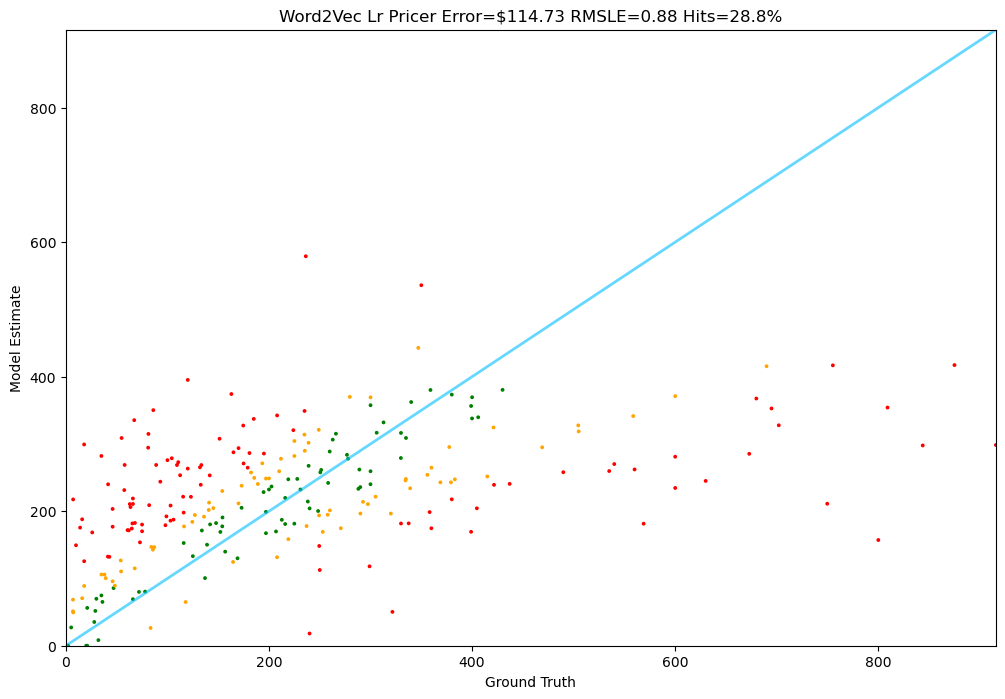

In [61]:
Tester.test(word2vec_lr_pricer)

In [62]:
# Support Vector Machines

np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

LinearSVR()

In [63]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

1: Guess: $145.92 Truth: $319.97 Error: $174.05 SLE: 0.61 Item: Cetol SRD Natural - 5 Gallons
2: Guess: $293.56 Truth: $184.99 Error: $108.57 SLE: 0.21 Item: Rhino-Rack Aluminum Roof Rack Tracks 58....
3: Guess: $194.95 Truth: $193.39 Error: $1.56 SLE: 0.00 Item: Delta Faucet 51600-SSN/An/A Includes 60"...
4: Guess: $155.85 Truth: $153.99 Error: $1.86 SLE: 0.00 Item: Texan Auto Seat Cover - Driver Bottom Le...
5: Guess: $93.14 Truth: $156.83 Error: $63.69 SLE: 0.27 Item: Dawn Enterprises FE2-4RUN Finished End B...
6: Guess: $201.96 Truth: $339.00 Error: $137.04 SLE: 0.27 Item: DIDER 22'' Farmhouse Ceiling Fan with Li...
7: Guess: $115.68 Truth: $17.99 Error: $97.69 SLE: 3.30 Item: Floor Lamp Shade 2 Pack Torchiere Lamp S...
8: Guess: $214.51 Truth: $180.75 Error: $33.76 SLE: 0.03 Item: OE Wheels LLC TY09-17075-6550-30MS Silve...
9: Guess: $149.81 Truth: $248.35 Error: $98.54 SLE: 0.25 Item: Taco 0011-009RP Series Replacement Cartr...
10: Guess: $140.52 Truth: $98.95 Error: $41.57 SLE: 

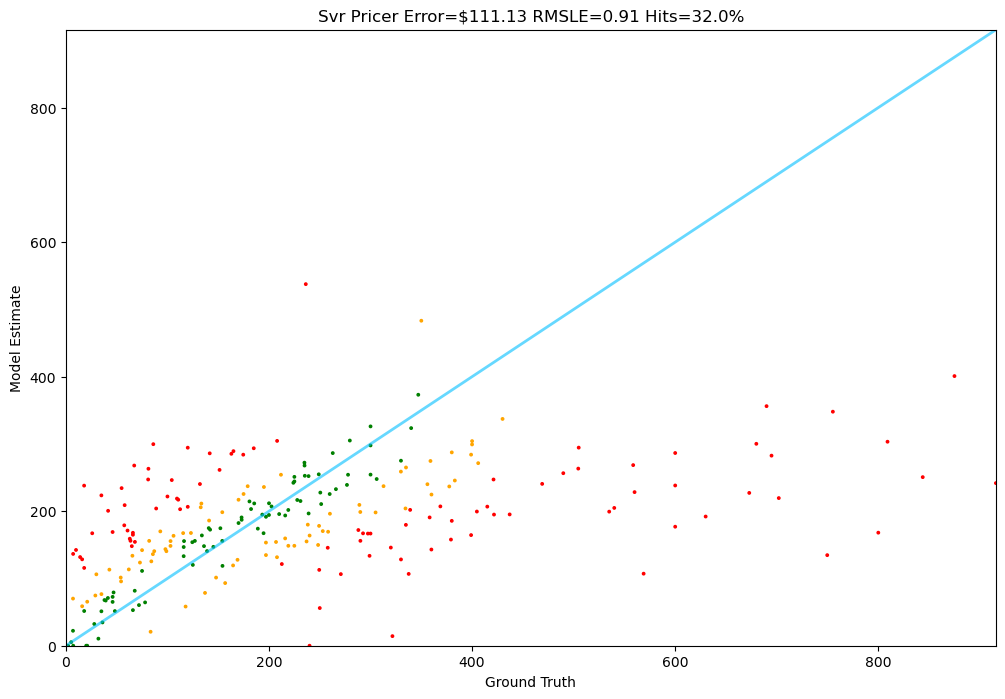

In [64]:
Tester.test(svr_pricer)

In [1]:
# And the powerful Random Forest regression

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X_w2v, prices)

NameError: name 'RandomForestRegressor' is not defined

In [ ]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

In [ ]:
Tester.test(random_forest_pricer)